In [303]:
from Advertising.learners.greedyLearner import *
import matplotlib.pyplot as plt
import numpy as np
from SocialNetwork.social_network_environment import *
from SocialNetwork.cascade import *
from Advertising.enviroment.bid import *
from Advertising.enviroment.VCG import *
from tqdm.autonotebook import tqdm
import itertools
random.seed(6789)
np.random.seed(6789)



In [304]:
deltas = [0.5, 0.42, 0.38, 0.30, 0.2, 0.05]
social_network = social_network_environment()
social_network.init_from_json(
    json_path_network='Config/network.json', json_path_features='Config/features.json')


In [305]:
def arms_creation(seed=None, number_of_arms=-1):
    arms = []
    if number_of_arms < 0:
        for i in itertools.product([0, 1, 2, 3, 4], repeat=5):
            arms.append(list(i))
    else:
        random.seed(seed)

        arms = []
        for i in range(0, number_of_arms):
            arm = []
            for i in range(0, 5):
                arm.append(random.randint(0, 4))
            arms.append(np.array(arm))
    return arms


In [306]:
active_by_influence_reward = compute_array_estimated_influence(
    social_network, 2000)


Doing node number 0
Doing node number 1
Doing node number 2
Doing node number 3
Doing node number 4
Doing node number 5
Doing node number 6
Doing node number 7
Doing node number 8
Doing node number 9
Doing node number 10
Doing node number 11
Doing node number 12
Doing node number 13
Doing node number 14
Doing node number 15
Doing node number 16
Doing node number 17
Doing node number 18
Doing node number 19
Doing node number 20
Doing node number 21
Doing node number 22
Doing node number 23
Doing node number 24
Doing node number 25
Doing node number 26
Doing node number 27
Doing node number 28
Doing node number 29
Doing node number 30
Doing node number 31
Doing node number 32
Doing node number 33
Doing node number 34
Doing node number 35
Doing node number 36
Doing node number 37
Doing node number 38
Doing node number 39
Doing node number 40
Doing node number 41
Doing node number 42
Doing node number 43
Doing node number 44
Doing node number 45
Doing node number 46
Doing node number 47
Do

In [307]:
class GTS_Learner():
    def __init__(self, n_arms, arms, variance=20, ad_id=1):
        self.n_arms = n_arms
        self.arms = arms
        self.tau = 1/variance  # precision of the Gaussian
        self.tau0 = np.ones(n_arms)*0.001
        self.u0 = np.zeros(n_arms)
        self.rewards_per_arm = [[] for i in range(self.n_arms)]
        self.t = 0
        self.ad_id = ad_id
        self.collected_rewards=[]

    def pull_arm(self):
        values = np.random.normal(self.u0, 1/self.tau0)
        pulled_arm = np.argmax(values)
        arm = self.arms[pulled_arm]
        bids = [Bid(arm[i], self.ad_id) for i in range(len(arm))]
        return bids, pulled_arm

#per risparmiare tempo passo l'indice dell'arm, e viene pullato insieme alle bid
    def update(self, index, reward):
        self.t += 1
        # aggiungo la reward a quelle ottenute
        self.rewards_per_arm[index].append(reward)

        self.collected_rewards.append(reward)
        # aggiorno i parametri della normale
        self.tau0[index] += self.t*self.tau
        rews = np.sum(self.rewards_per_arm[index])

        self.u0[index] = (self.tau0[index]*self.u0[index] +
                          self.tau*rews)/(self.tau0[index]+(self.t*self.tau))


In [308]:
def test(learner, arms, bids_adversaries, only_first, active_by_influence_reward, n_rounds, point5):
    for i in tqdm(range(n_rounds)):

        
        bids, pulled_arm = learner.pull_arm()

        for j in range(5):
            bids_adversaries[j][0] = bids[j]
    
        best_allocation = vcg.all_best_allocations(
            list_camp_bids=bids_adversaries, social_network=social_network)

        if only_first:
            for j in range(0, len(best_allocation)):
                temp_allocation = []
                temp_allocation = best_allocation[j]
                for k in range(0, len(best_allocation[j])):
                    if temp_allocation[k].ad_id == 1 and k != 0:
                        temp_allocation[k].ad_id = None
                        best_allocation[j] = temp_allocation


        if not point5:                
            active_nodes, click_rewards = active_nodes_click( social_network, best_allocation, lambdas, 1)
        else:
            total_reward, active_nodes = activate_cascade(
                social_network=social_network, ad_allocation_list=best_allocation, slot_prominence=deltas, learner_id=1)

        payments = np.array(vcg.payments(bids_adversaries, best_allocation, social_network=social_network))
    # with this part of code i set that if the learner is present in the allocation list then get the normal allocation
    # reward, if it's not present and it bids 0 then the reward is 0.
        payments_tot = calculate_total_payment(payments, social_network.categories, active_nodes)

        if not point5: 
            reward = 0
            reward_influence = 0
            indexes = np.where(active_nodes == 1)[0]

            if len(indexes) != 0:
                for i in range(0, len(indexes)):
                    reward_influence += active_by_influence_reward[i]
                reward_influence = (reward_influence/len(indexes) + reward_influence)/2
                reward = (click_rewards + reward_influence - payments_tot)
        else:
            reward=total_reward-payments_tot
        
        reset_nodes(social_network=social_network)

        #rew = reward-np.sum(payments_tot)

    # updating of the learners
        learner.update(pulled_arm, reward)

    plt.figure(0)
    plt.xlabel('round')
    plt.ylabel('reward')
    plt.plot(learner.collected_rewards)
    plt.show()

    print("THE BEST ARM IS:",
          arms[learner.pull_arm()[1]], "INDEX",learner.pull_arm()[1])
    array = [i+1 for i in range(0, 20)]

    plt.figure(1)
    plt.errorbar(array, ts_learner.u0, yerr=(1/ts_learner.tau0)*5, fmt='o')
    plt.show()
    


In [309]:
arms = arms_creation(30291,20)
lambdas = [0.5, 0.42, 0.38, 0.30, 0.2, 0.05]
vcg = VCG()

bids_adversaries = []
for i in range(0, 5):
    bid_categoria = np.array([])
    for j in range(0, 11):  # number of competitors
        bid = Bid(bid=random.randint(1, 4), id=j+3)
        bid_categoria = np.append(bid_categoria, bid)
    bids_adversaries.append(bid_categoria)


100%|██████████| 5000/5000 [00:19<00:00, 255.61it/s]


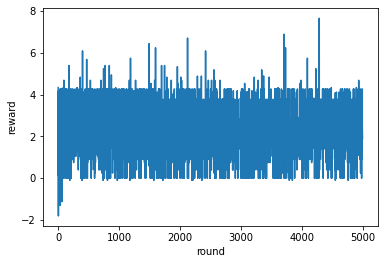

THE BEST ARM IS: [2 1 3 0 4] INDEX 7


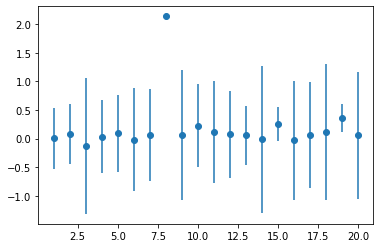

100%|██████████| 5000/5000 [00:15<00:00, 326.56it/s]


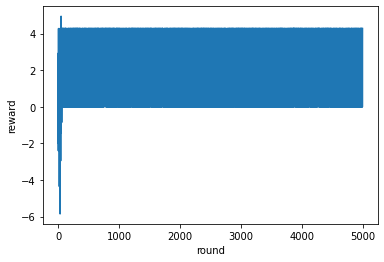

THE BEST ARM IS: [1 1 2 0 4] INDEX 4


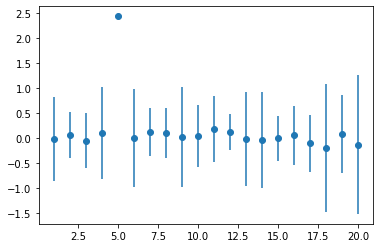

In [310]:
ts_learner = GTS_Learner(n_arms=len(arms), arms=arms,
                         variance=10, ad_id=1)
only_first=True

test(ts_learner, arms, bids_adversaries,
     False, active_by_influence_reward, 5000, False)
ts_learner1 = GTS_Learner(n_arms=len(arms), arms=arms,
                         variance=10, ad_id=1)
test(ts_learner1, arms, bids_adversaries, True, active_by_influence_reward, 5000, False)


In [311]:
class SWGTS_Learner():
    def __init__(self, n_arms, arms, variance=20, ad_id=1):
        self.n_arms = n_arms
        self.arms = arms
        self.tau = 1/variance  # precision of the Gaussian
        self.tau0 = np.ones(n_arms)*0.0001
        self.u0 = np.zeros(n_arms)
        self.rewards_per_arm = [[] for i in range(self.n_arms)]
        self.t = 0
        self.ad_id = ad_id
        self.collected_rewards = []
        self.collected_tau0 = [[] for i in range(n_arms)]
        self.isSw=False
        self.sizeSw=0

    def pull_arm(self):
        values = np.random.normal(self.u0, 1/self.tau0)
        pulled_arm = np.argmax(values)
        arm = self.arms[pulled_arm]
        bids = [Bid(arm[i], self.ad_id) for i in range(len(arm))]
        return bids, pulled_arm

#per risparmiare tempo passo l'indice dell'arm, e viene pullato insieme alle bid
    def update(self, index, reward):
        self.rewards_per_arm[index].append(reward)
        self.t += 1

        self.collected_rewards.append(reward)

        if not self.isSw:                
        # aggiorno i parametri della normale
            self.tau0[index] += self.t*self.tau
            rews = np.sum(self.rewards_per_arm[index])

            self.u0[index] = (self.tau0[index]*self.u0[index] +
                          self.tau*rews)/(self.tau0[index]+(self.t*self.tau))
        else:
            rews = np.sum(self.rewards_per_arm[index][-self.sizeSW:])
            if self.t>self.sizeSW: self.t=self.sizeSW
            self.collected_tau0[index].append(self.tau0[index])

            self.tau0[index] = np.sum(
                self.collected_tau0[index][-self.sizeSW:])+self.t*self.tau
            self.u0[index] = (self.tau0[index]*self.u0[index] +
                                              self.tau*rews)/(self.tau0[index]+(self.t*self.tau))
    def activateSW(self, sizeSW):
        self.sizeSW =sizeSW
        self.isSw=True


 22%|██▏       | 1084/5000 [00:04<00:13, 284.23it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-311-824f5a75c9d9>:44: RuntimeWarning: invalid value encountered in double_scalars
  self.u0[index] = (self.tau0[index]*self.u0[index] +
100%|██████████| 5000/5000 [00:19<00:00, 262.48it/s]


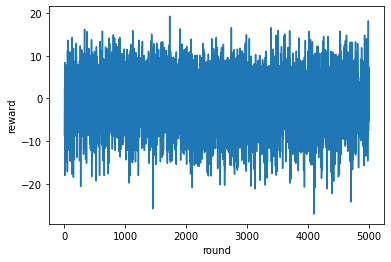

array([1, 3, 3, 1, 4])

In [312]:
ts_learner = SWGTS_Learner(n_arms=len(arms), arms=arms,
                         variance=20, ad_id=1)

sizesw=2000
ts_learner.activateSW(sizesw)

t=10000                       
for i in tqdm(range(5000)):
    t+=1
    if t>sizesw:
        bids_adversaries = []
        for i in range(0, 5):
            bid_categoria = np.array([])
            for j in range(0, 11):  # number of competitors
                bid = Bid(bid=random.randint(1, 4), id=j+3)
                bid_categoria = np.append(bid_categoria, bid)
            bids_adversaries.append(bid_categoria)
        t=0


    bids, pulled_arm = ts_learner.pull_arm()

    for j in range(5):
        bids_adversaries[j][0] = bids[j]

    best_allocation = vcg.all_best_allocations(
        list_camp_bids=bids_adversaries, social_network=social_network)
    reward = activate_cascade(social_network=social_network,
                              ad_allocation_list=best_allocation, slot_prominence=lambdas)[0]

    active_nodes, click_rewards = active_nodes_click(
        social_network, best_allocation, lambdas, 1)
    payments = np.array(vcg.payments(
        bids_adversaries, best_allocation, social_network=social_network))

    # with this part of code i set that if the learner is present in the allocation list then get the normal allocation
    # reward, if it's not present and it bids 0 then the reward is 0.
    payments_tot = calculate_total_payment(
        payments, social_network.categories, active_nodes)

    reset_nodes(social_network=social_network)

    rew = reward-np.sum(payments_tot)

    # updating of the learners
    ts_learner.update(pulled_arm, rew)

plt.figure(0)
plt.xlabel('round')
plt.ylabel('reward')
plt.plot(ts_learner.collected_rewards)
plt.show()

arms[ts_learner.pull_arm()[1]]


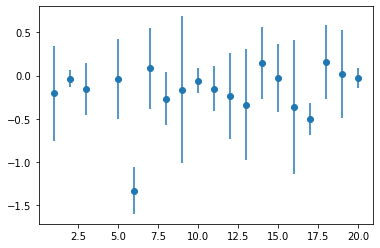

In [313]:
array = [i+1 for i in range(0, 20)]
plt.figure(0)
plt.errorbar(array, ts_learner.u0, yerr=(1/ts_learner.tau0)*5, fmt='o')
plt.show()
